In [18]:
# ============================================================
# WEEK 13 - LESSON 4
# Final Notebook/Report Program (Hotel Bookings Dataset)
# Dataset: https://raw.githubusercontent.com/swapnilsaurav/Dataset/refs/heads/master/hotel_bookings.csv
# Target: is_canceled (0 = not canceled, 1 = canceled)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

import joblib
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42


# -----------------------------
# 1) Problem Statement & KPIs
# -----------------------------
"""
Business Objective:
Predict booking cancellation (is_canceled) using stable, clean, meaningful features.

Preprocessing KPIs (data-ready success):
- Missing values handled with defensible strategies
- Categorical consistency ensured (unknowns handled)
- Numeric scaling applied properly (after split, on train only)
- High-dimensional one-hot compressed using SVD for stability and speed
- Anomalies detected and flagged (not blindly removed)
- Pipeline is reproducible and deployable (saved artifacts)
"""


'\nBusiness Objective:\nPredict booking cancellation (is_canceled) using stable, clean, meaningful features.\n\nPreprocessing KPIs (data-ready success):\n- Missing values handled with defensible strategies\n- Categorical consistency ensured (unknowns handled)\n- Numeric scaling applied properly (after split, on train only)\n- High-dimensional one-hot compressed using SVD for stability and speed\n- Anomalies detected and flagged (not blindly removed)\n- Pipeline is reproducible and deployable (saved artifacts)\n'

In [19]:
# -----------------------------
# 2) Load Dataset
# -----------------------------
DATA_URL = "https://raw.githubusercontent.com/swapnilsaurav/Dataset/refs/heads/master/hotel_bookings.csv"
df = pd.read_csv(DATA_URL)

print("Raw shape:", df.shape)
print(df.head(3))

# -----------------------------
# 3) Basic Sanity Checks
# -----------------------------
if "is_canceled" not in df.columns:
    raise ValueError("Target column 'is_canceled' not found in dataset.")

print("\nMissing values (top 15):")
print(df.isna().sum().sort_values(ascending=False).head(15))

print("\nTarget distribution:")
target_col = "is_canceled"
print(df[target_col].value_counts(dropna=False))

# Safety: drop rows where target missing (rare but keeps alignment perfect)
df = df.dropna(subset=[target_col])

Raw shape: (119390, 33)
   id         hotel  is_canceled  lead_time  arrival_date_year  \
0   1  Resort Hotel          0.0      342.0               2015   
1   2  Resort Hotel          0.0      737.0               2015   
2   3  Resort Hotel          0.0        7.0               2015   

  arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
0               July                      27.0                        1.0   
1               July                      27.0                        1.0   
2               July                      27.0                        1.0   

   stays_in_weekend_nights  stays_in_week_nights  ...  deposit_type  agent  \
0                      0.0                   0.0  ...    No Deposit    NaN   
1                      0.0                   0.0  ...    No Deposit    NaN   
2                      0.0                   1.0  ...    No Deposit    NaN   

   company days_in_waiting_list customer_type   adr  \
0      NaN                  0.0   

In [20]:
# -----------------------------
# 4) Feature Engineering (Hotel-Specific)
#    Keep it simple, meaningful, explainable.
# -----------------------------
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    d = data.copy()

    # Ensure typical missing numeric values are filled before derived features
    for col in ["children", "babies", "adults", "stays_in_weekend_nights", "stays_in_week_nights"]:
        if col in d.columns:
            d[col] = d[col].fillna(0)

    # Total nights
    if "stays_in_weekend_nights" in d.columns and "stays_in_week_nights" in d.columns:
        d["total_nights"] = d["stays_in_weekend_nights"] + d["stays_in_week_nights"]
    else:
        d["total_nights"] = np.nan

    # Total guests
    if set(["adults", "children", "babies"]).issubset(d.columns):
        d["total_guests"] = d["adults"] + d["children"] + d["babies"]
    else:
        d["total_guests"] = np.nan

    # Family flag
    if set(["children", "babies"]).issubset(d.columns):
        d["is_family"] = ((d["children"] + d["babies"]) > 0).astype(int)
    else:
        d["is_family"] = 0

    # ADR per person (avoid divide by zero)
    if "adr" in d.columns and "total_guests" in d.columns:
        denom = d["total_guests"].replace(0, np.nan)
        d["adr_per_person"] = d["adr"] / denom
    else:
        d["adr_per_person"] = np.nan

    # Lead time log transform (reduce skew)
    if "lead_time" in d.columns:
        d["lead_time_log1p"] = np.log1p(d["lead_time"].clip(lower=0))
    else:
        d["lead_time_log1p"] = np.nan

    # Month mapping (arrival_date_month is usually text)
    # Convert month name -> month number for better modeling
    if "arrival_date_month" in d.columns:
        month_map = {
            "January": 1, "February": 2, "March": 3, "April": 4,
            "May": 5, "June": 6, "July": 7, "August": 8,
            "September": 9, "October": 10, "November": 11, "December": 12
        }
        d["arrival_month_num"] = d["arrival_date_month"].map(month_map)
    else:
        d["arrival_month_num"] = np.nan

    # Booking intensity: special requests per night (proxy for intent/complexity)
    if "total_of_special_requests" in d.columns and "total_nights" in d.columns:
        denom = d["total_nights"].replace(0, np.nan)
        d["requests_per_night"] = d["total_of_special_requests"] / denom
    else:
        d["requests_per_night"] = np.nan

    return d


df_fe = feature_engineering(df)

# (Optional) Drop columns that can cause leakage or are post-outcome.
# Example: reservation_status_date could contain future-ish timing relative to label creation.
# We'll drop date string columns and obvious post-decision fields if present.
LEAKY_OR_LOW_VALUE = [
    "reservation_status_date",   # date string; can leak timeline info
    "reservation_status"         # status often correlated with cancellation outcome
]
for c in LEAKY_OR_LOW_VALUE:
    if c in df_fe.columns:
        df_fe = df_fe.drop(columns=[c])

print("\nAfter feature engineering shape:", df_fe.shape)




After feature engineering shape: (119380, 38)


In [21]:
# -----------------------------
# 5) Train/Test Split (No Leakage)
# -----------------------------
X = df_fe.drop(columns=["is_canceled"])
y = df_fe["is_canceled"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("\nTrain shape:", X_train.shape, "| Test shape:", X_test.shape)




Train shape: (95504, 37) | Test shape: (23876, 37)


In [22]:
# -----------------------------
# 6) Identify Column Types
#    Note: object columns treated as categorical.
# -----------------------------
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

print("\nNumeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))




Numeric features: 27
Categorical features: 10


In [23]:
# -----------------------------
# 7) Preprocessing Pipelines
# -----------------------------
# Numeric: median impute + standard scale
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical: most_frequent impute + one-hot
# Use sparse output to keep memory manageable.
categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ],
    remainder="drop"
)



In [24]:
# -----------------------------
# 8) Fit/Transform
# -----------------------------
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

print("\nAfter preprocessing:")
print("Train matrix shape:", X_train_prep.shape)
print("Test matrix shape:", X_test_prep.shape)



After preprocessing:
Train matrix shape: (95504, 256)
Test matrix shape: (23876, 256)


In [25]:
# -----------------------------
# 9) Feature Filtering: Remove Near-Zero Variance
#    Works with sparse matrices.
# -----------------------------
var_filter = VarianceThreshold(threshold=0.0001)
X_train_var = var_filter.fit_transform(X_train_prep)
X_test_var = var_filter.transform(X_test_prep)

print("\nAfter VarianceThreshold:")
print("Train matrix shape:", X_train_var.shape)




After VarianceThreshold:
Train matrix shape: (95504, 174)


In [26]:
# -----------------------------
# 10) Dimensionality Reduction
#     For one-hot sparse data, use TruncatedSVD (SVD is appropriate; PCA isn't ideal here)
# -----------------------------
# Choose components based on size; keep it practical for reporting.
# Rule of thumb: 50–200 for demos; increase for larger modeling needs.
N_COMPONENTS = 80

svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=RANDOM_STATE)
X_train_svd = svd.fit_transform(X_train_var)
X_test_svd = svd.transform(X_test_var)

print("\nAfter TruncatedSVD:")
print("Train reduced shape:", X_train_svd.shape)
print("Explained variance ratio (approx):", float(np.sum(svd.explained_variance_ratio_)))




After TruncatedSVD:
Train reduced shape: (95504, 80)
Explained variance ratio (approx): 0.9975419156493947


In [27]:
# -----------------------------
# 11) Anomaly Detection
#     Strategy: Flag anomalies instead of removing.
# -----------------------------
# LOF: only fit_predict on train (no separate predict API reliably for novelty=False)
lof = LocalOutlierFactor(n_neighbors=25, contamination=0.03)
lof_train_labels = lof.fit_predict(X_train_svd)  # -1 anomaly, 1 normal
lof_train_flag = (lof_train_labels == -1).astype(int)

# Isolation Forest: can predict train + test
iso = IsolationForest(
    n_estimators=300,
    contamination=0.03,
    random_state=RANDOM_STATE
)
iso.fit(X_train_svd)

iso_train_labels = iso.predict(X_train_svd)  # -1 anomaly, 1 normal
iso_test_labels = iso.predict(X_test_svd)

iso_train_flag = (iso_train_labels == -1).astype(int)
iso_test_flag = (iso_test_labels == -1).astype(int)


In [29]:
# -----------------------------
# 12) Final Feature Set
#     Add anomaly flags as final features
# -----------------------------
X_train_final = np.column_stack([X_train_svd, lof_train_flag, iso_train_flag])

# LOF flag not available on test (by design). Use -1 sentinel or 0.
# Here we put a neutral 0 for LOF test flag to keep schema consistent.
lof_test_flag = np.zeros(shape=(X_test_svd.shape[0],), dtype=int)
X_test_final = np.column_stack([X_test_svd, lof_test_flag, iso_test_flag])

print("\nFinal Train shape:", X_train_final.shape)
print("Final Test shape:", X_test_final.shape)



Final Train shape: (95504, 82)
Final Test shape: (23876, 82)


In [30]:
# -----------------------------
# 13) Preprocessing Impact Summary (Report-Ready)
# -----------------------------
impact_summary = {
    "Raw feature columns (X)": X.shape[1],
    "After preprocessing (encoded)": X_train_prep.shape[1],
    "After variance filtering": X_train_var.shape[1],
    "After SVD (compressed)": X_train_svd.shape[1],
    "Final features (+anomaly flags)": X_train_final.shape[1],
    "Approx explained variance (SVD)": float(np.sum(svd.explained_variance_ratio_)),
    "Train anomaly rate (LOF)": float(np.mean(lof_train_flag)),
    "Train anomaly rate (IsoForest)": float(np.mean(iso_train_flag)),
    "Test anomaly rate (IsoForest)": float(np.mean(iso_test_flag))
}

impact_df = pd.DataFrame.from_dict(impact_summary, orient="index", columns=["Value"])
print("\n=== PREPROCESSING IMPACT SUMMARY ===")
print(impact_df)



=== PREPROCESSING IMPACT SUMMARY ===
                                      Value
Raw feature columns (X)           37.000000
After preprocessing (encoded)    256.000000
After variance filtering         174.000000
After SVD (compressed)            80.000000
Final features (+anomaly flags)   82.000000
Approx explained variance (SVD)    0.997542
Train anomaly rate (LOF)           0.030009
Train anomaly rate (IsoForest)     0.030009
Test anomaly rate (IsoForest)      0.031454


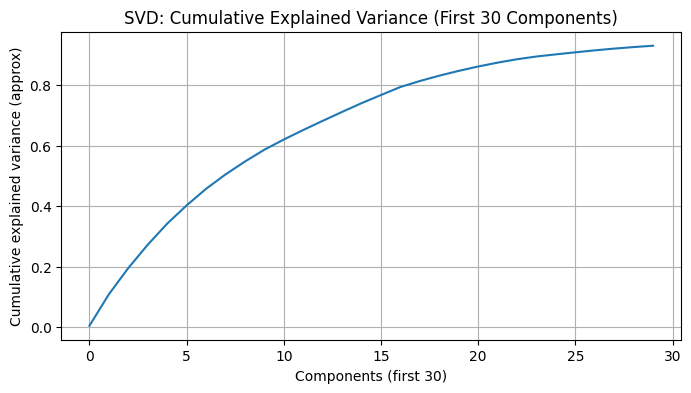

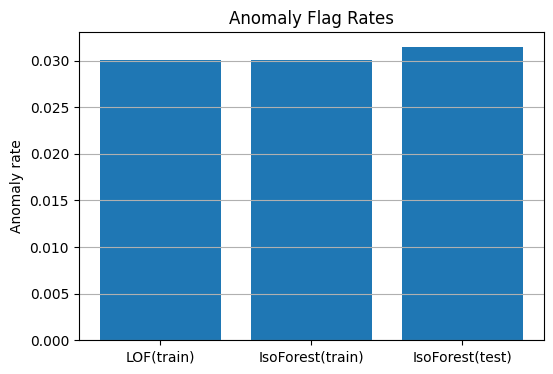

In [31]:
# -----------------------------
# 14) Simple Visual Checks (Report-Friendly)
# -----------------------------
# A) SVD explained variance contribution (first 30 components)
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(svd.explained_variance_ratio_[:30]))
plt.xlabel("Components (first 30)")
plt.ylabel("Cumulative explained variance (approx)")
plt.title("SVD: Cumulative Explained Variance (First 30 Components)")
plt.grid(True)
plt.show()

# B) Anomaly rates (train)
plt.figure(figsize=(6, 4))
plt.bar(["LOF(train)", "IsoForest(train)", "IsoForest(test)"],
        [np.mean(lof_train_flag), np.mean(iso_train_flag), np.mean(iso_test_flag)])
plt.ylabel("Anomaly rate")
plt.title("Anomaly Flag Rates")
plt.grid(axis="y")
plt.show()



In [32]:
# -----------------------------
# 15) Save Artifacts for Deployment
#     Save only what you need to reproduce transformations.
# -----------------------------
ARTIFACTS_PATH = "hotel_preprocessing_artifacts.joblib"

artifacts = {
    "preprocessor": preprocessor,
    "variance_filter": var_filter,
    "svd": svd,
    "iso_forest": iso,
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "N_COMPONENTS": N_COMPONENTS,
    "random_state": RANDOM_STATE
}

joblib.dump(artifacts, ARTIFACTS_PATH)
print(f"\nArtifacts saved to: {ARTIFACTS_PATH}")



Artifacts saved to: hotel_preprocessing_artifacts.joblib


In [33]:
# -----------------------------
# 16) (Optional) Helper: Transform New Data for Production
# -----------------------------
def transform_new_data(raw_df: pd.DataFrame, artifacts_path: str) -> np.ndarray:
    """
    Transform raw input data into the final feature matrix used for modeling.
    This mirrors the training preprocessing pipeline.

    Note:
    - LOF flag for new data is not computed here (LOF is train-only in this setup),
      so we set LOF flag = 0 for new rows.
    - IsoForest flag is computed and appended.
    """
    artifacts_local = joblib.load(artifacts_path)

    preproc = artifacts_local["preprocessor"]
    vfilter = artifacts_local["variance_filter"]
    svd_local = artifacts_local["svd"]
    iso_local = artifacts_local["iso_forest"]

    # apply same feature engineering and same column drops
    d = feature_engineering(raw_df)
    for c in LEAKY_OR_LOW_VALUE:
        if c in d.columns:
            d = d.drop(columns=[c])

    Xp = preproc.transform(d)
    Xv = vfilter.transform(Xp)
    Xr = svd_local.transform(Xv)

    iso_flag = (iso_local.predict(Xr) == -1).astype(int)
    lof_flag = np.zeros((Xr.shape[0],), dtype=int)

    X_final = np.column_stack([Xr, lof_flag, iso_flag])
    return X_final

print("\nPipeline is ready for notebook/report submission and deployment reuse.")



Pipeline is ready for notebook/report submission and deployment reuse.


<h2>Build and Predict using a Cassification Model</h2>

<h4>This is not included in the video lecture but you are encouraged to practice <br>You already ran the preprocessing notebook and saved artifacts as:
hotel_preprocessing_artifacts.joblib
</h4>

In [34]:
import joblib
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

X_train_final
X_test_final
y_train
y_test

69389     1
31255     0
98700     0
85402     0
63576     1
         ..
114470    0
3550      1
113055    0
96922     0
21787     0
Name: is_canceled, Length: 23876, dtype: int64

In [35]:
#train the model
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",   # important for imbalance
    random_state=42
)

model.fit(X_train_final, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [36]:
# Class predictions
y_pred = model.predict(X_test_final)

# Probability predictions (needed for ROC-AUC)
y_pred_proba = model.predict_proba(X_test_final)[:, 1]


In [37]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_auc


0.9886697621598987

In [38]:
precision = precision_score(y_test, y_pred)
precision


0.9113253522618922

In [39]:
recall = recall_score(y_test, y_pred)
recall


0.9725268513284342

In [41]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

pd.DataFrame(
    cm,
    index=["Actual: Not Canceled", "Actual: Canceled"],
    columns=["Predicted: Not Canceled", "Predicted: Canceled"]
)


,Predicted: Not Canceled,Predicted: Canceled
Actual: Not Canceled,14194,837
Actual: Canceled,243,8602


In [42]:
#Full Classification Report (Optional but Recommended)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.94      0.96     15031
           1       0.91      0.97      0.94      8845

    accuracy                           0.95     23876
   macro avg       0.95      0.96      0.95     23876
weighted avg       0.96      0.95      0.96     23876

